<a href="https://colab.research.google.com/github/namangarg1805/Data-Analytics/blob/main/Chatbot_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LangChain:
1. Open Source Framework
2. help in developing applications that uses LLMS
3. It is compatible with many llm's model.

In [1]:
# Installing necessary libraties
!pip install langchain-core langgraph>0.2.27
!pip install -qU langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.2/412.2 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.6 MB/s eta 0:00:00


In [2]:
import getpass
import os
os.environ["LANGSMITH_TRACING"] = "true"

In [3]:
from langchain_openai import ChatOpenAI

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

if not os.environ.get("LANGSMITH_API_KEY"):
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter LangSmith API key for tracing: ")
    os.environ["LANGSMITH_TRACING"] = "true"

model = ChatOpenAI(model="gpt-4o-mini")

Enter API key for OpenAI: ··········
Enter LangSmith API key for tracing: ··········


In [4]:
# Checking model
from langchain_core.messages import HumanMessage

res = model.invoke([HumanMessage(content="Hi! I'm Bob")])

In [5]:
from langchain_core.messages import AIMessage

model.invoke([
    HumanMessage(content="Hi! I am Bob"),
    AIMessage(content = "Hi Bob! How can I assist you today?"),
    HumanMessage(content="What is my name?")
    ]).content

'Your name is Bob. How can I help you today, Bob?'

LangGraph:
1. Open Source Framework
2. Developed by LangChain inc
3. caan be used independently
4. stateful control of applications
5. LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows.
6.  As a very low-level framework, it provides fine-grained control over both the flow and state of your application, crucial for creating reliable agents. Additionally, LangGraph includes built-in persistence, enabling advanced human-in-the-loop and memory features.


Key Features¶
Cycles and Branching: Implement loops and conditionals in your apps.
Persistence: Automatically save state after each step in the graph. Pause and resume the graph execution at any point to support error recovery, human-in-the-loop workflows, time travel and more.
Human-in-the-Loop: Interrupt graph execution to approve or edit next action planned by the agent.
Streaming Support: Stream outputs as they are produced by each node (including token streaming).
Integration with LangChain: LangGraph integrates seamlessly with LangChain and LangSmith (but does not require them).

LangGraph Course points:
1. Fixed chains vs LLM(brain) chains which are termed as agent
2. LLM chains:
    1. Router -
    2. Fully Autonomous
3. LanGraph increases reliability of Fully Autonomous agents.
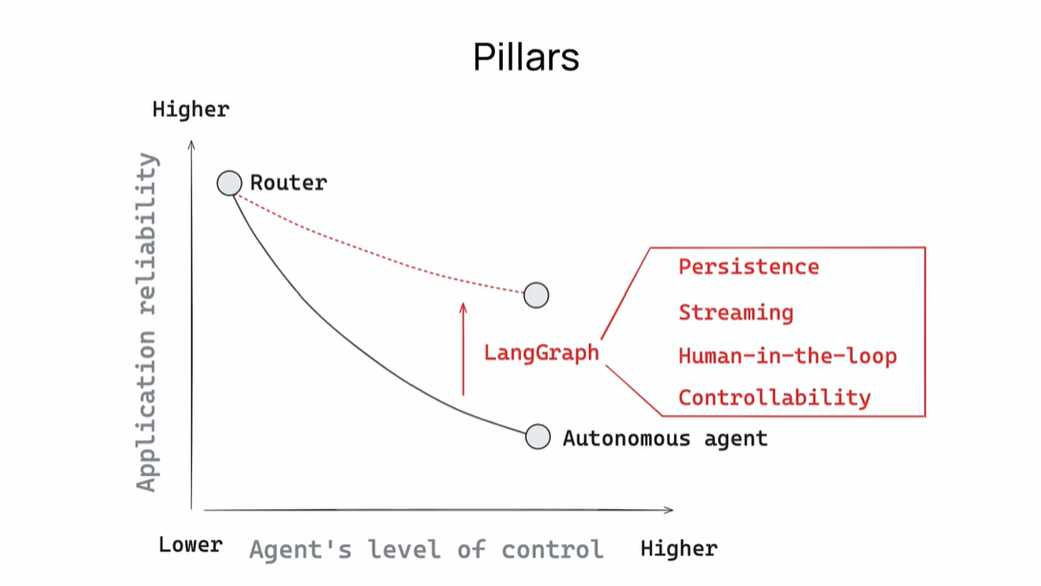


Nodes - content
Edges - can be conditional
StateGraph()
State:
graph_state:dict
add nodes
edgese
compile


In [10]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

In [11]:
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

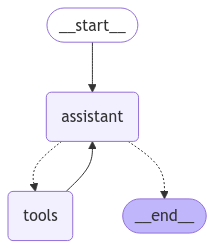

In [12]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [13]:
messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_lHzD21W9YTE8GD3AG0i1daIh)
 Call ID: call_lHzD21W9YTE8GD3AG0i1daIh
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [14]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================

Could you please provide the number you would like to multiply by 2?


In [15]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

In [16]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_sNd96HB0IN5VwnvT8Vyc4NUi)
 Call ID: call_sNd96HB0IN5VwnvT8Vyc4NUi
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [17]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_sNd96HB0IN5VwnvT8Vyc4NUi)
 Call ID: call_sNd96HB0IN5VwnvT8Vyc4NUi
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_znbApJlcZAkJAzQVrR3ODuiv)
 Call ID: call_znbApJlcZAkJAzQVrR3ODuiv
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

Multiplying 7 by 2 gi